### 赛题分析

预测房屋的租金，很明显是个回归问题。评价指标为R Squared score，
$R^2$值越接近1模型效果越好
$$
R^2 = 1-\frac{\sum_i^m{(\hat{y_i}-y_i)^2}}{\sum_i^m{(\overline{y_i}-y_i)^2}}
$$

### EDA

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(context="notebook", style="darkgrid")
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

训练集41440条样本，测试集2469条样本，50个原始特征，预测目标为‘tradeMoney’

In [2]:
train = pd.read_csv('./data/train_data.csv')
test = pd.read_csv('./data/test_a.csv')
print(train.shape)
print(test.shape)

(41440, 51)
(2469, 50)


In [3]:
train.head()

,ID,area,rentType,houseType,houseFloor,totalFloor,houseToward,houseDecoration,communityName,city,...,landTotalPrice,landMeanPrice,totalWorkers,newWorkers,residentPopulation,pv,uv,lookNum,tradeTime,tradeMoney
0,100309852,68.06,未知方式,2室1厅1卫,低,16,暂无数据,其他,XQ00051,SH,...,0,0.0000,28248,614,111546,1124.0,284.0,0,2018/11/28,2000.0
1,100307942,125.55,未知方式,3室2厅2卫,中,14,暂无数据,简装,XQ00130,SH,...,0,0.0000,14823,148,157552,701.0,22.0,1,2018/12/16,2000.0
2,100307764,132.00,未知方式,3室2厅2卫,低,32,暂无数据,其他,XQ00179,SH,...,0,0.0000,77645,520,131744,57.0,20.0,1,2018/12/22,16000.0
3,100306518,57.00,未知方式,1室1厅1卫,中,17,暂无数据,精装,XQ00313,SH,...,332760000,3080.0331,8750,1665,253337,888.0,279.0,9,2018/12/21,1600.0
4,100305262,129.00,未知方式,3室2厅3卫,低,2,暂无数据,毛坯,XQ01257,SH,...,0,0.0000,800,117,125309,2038.0,480.0,0,2018/11/18,2900.0


In [4]:
test.head()

,ID,area,rentType,houseType,houseFloor,totalFloor,houseToward,houseDecoration,communityName,city,...,tradeLandArea,landTotalPrice,landMeanPrice,totalWorkers,newWorkers,residentPopulation,pv,uv,lookNum,tradeTime
0,100000079,36.54,未知方式,1室1厅1卫,高,21,西北,其他,XQ03867,SH,...,0.00,0,0.0,41503,319,301635,1601.0,397.0,2,2018/10/25
1,100000138,64.00,未知方式,2室1厅1卫,高,11,南北,其他,XQ00821,SH,...,0.00,0,0.0,4370,0,306857,21123.0,3066.0,0,2018/8/19
2,100000192,98.00,未知方式,3室1厅1卫,高,6,暂无数据,精装,XQ00842,SH,...,0.00,0,0.0,4370,0,306857,17471.0,2554.0,0,2018/3/4
3,100000200,43.45,未知方式,1室1厅1卫,高,6,暂无数据,其他,XQ00786,SH,...,0.00,0,0.0,4370,0,306857,19231.0,2016.0,0,2018/2/3
4,100000430,92.00,未知方式,2室2厅1卫,高,6,暂无数据,其他,XQ01201,SH,...,237828.35,1078790000,4536.0,20904,0,245872,26189.0,2957.0,0,2018/3/14


查看数据集信息,object列为字符类型或字符与数值混合类型需要额外处理

In [5]:
target = 'tradeMoney'
test[target] = -1

In [6]:
data = pd.concat([train,test])
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43909 entries, 0 to 2468
Data columns (total 51 columns):
ID                    43909 non-null int64
area                  43909 non-null float64
rentType              43909 non-null object
houseType             43909 non-null object
houseFloor            43909 non-null object
totalFloor            43909 non-null int64
houseToward           43909 non-null object
houseDecoration       43909 non-null object
communityName         43909 non-null object
city                  43909 non-null object
region                43909 non-null object
plate                 43909 non-null object
buildYear             43909 non-null object
saleSecHouseNum       43909 non-null int64
subwayStationNum      43909 non-null int64
busStationNum         43909 non-null int64
interSchoolNum        43909 non-null int64
schoolNum             43909 non-null int64
privateSchoolNum      43909 non-null int64
hospitalNum           43909 non-null int64
drugStoreNum        

In [7]:
columns = data.columns.tolist()
columns.remove(target)
object_col = ['buildYear','city','communityName','houseDecoration','houseFloor','houseToward','houseType',
             'plate','region','rentType','tradeTime'] # object型特征
num_col = [x for x in columns if x not in object_col] # 数值型特征

In [8]:
data[object_col].head() # 把暂无信息,其他,暂无数据,未知方式也当做缺失，放到后面处理

,buildYear,city,communityName,houseDecoration,houseFloor,houseToward,houseType,plate,region,rentType,tradeTime
0,1953,SH,XQ00051,其他,低,暂无数据,2室1厅1卫,BK00064,RG00001,未知方式,2018/11/28
1,2007,SH,XQ00130,简装,中,暂无数据,3室2厅2卫,BK00049,RG00002,未知方式,2018/12/16
2,暂无信息,SH,XQ00179,其他,低,暂无数据,3室2厅2卫,BK00050,RG00002,未知方式,2018/12/22
3,暂无信息,SH,XQ00313,精装,中,暂无数据,1室1厅1卫,BK00051,RG00002,未知方式,2018/12/21
4,暂无信息,SH,XQ01257,毛坯,低,暂无数据,3室2厅3卫,BK00044,RG00003,未知方式,2018/11/18


Label分布

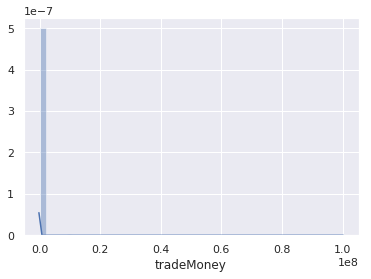

In [9]:
sns.distplot(train[target], bins=50) # 有离群点干扰

In [10]:
train[target].describe() # 最大值1亿应该属于异常

count    4.144000e+04
mean     8.837074e+03
std      5.514287e+05
min      0.000000e+00
25%      2.800000e+03
50%      4.000000e+03
75%      5.500000e+03
max      1.000000e+08
Name: tradeMoney, dtype: float64

(38670, 51)


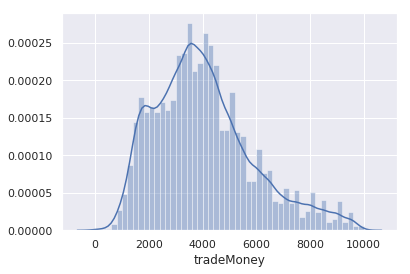

(2406, 51)


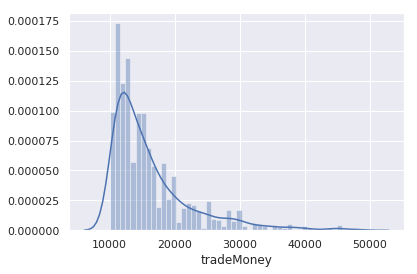

(38, 51)


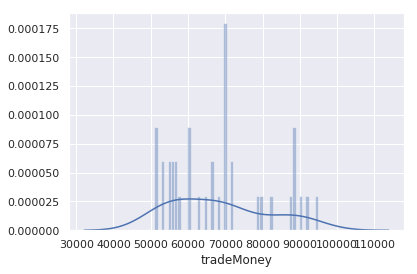

(19, 51)


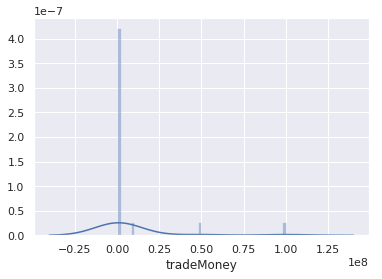

In [11]:
# 大致划了四个区间
train_10 = train[train[target]>100000]
train_5 =  train[train[target]>50000][train[target]<100000]
train_1 =  train[train[target]>10000][train[target]<50000]
train_0 =  train[train[target]<10000]
train_splits = [train_0,train_1,train_5,train_10]
for i in train_splits:
    print(i.shape)
    sns.distplot(i[target], bins=50)
    plt.show()

In [12]:
# 把月租金大于5w的样本去除
train = train[train[target]<50000]
data = data[data[target]<50000]

缺失值

In [13]:
for i in range(data[columns].shape[1]):
    lost = data[columns].iloc[:,i].isnull().sum()
    if lost>0:
        print(columns[i],':',lost)

pv : 20
uv : 20


In [14]:
# 使用均值填充
data['pv'] = data['pv'].fillna(data['pv'].mean())
data['uv'] = data['uv'].fillna(data['uv'].mean())

对buildYear,houseDecoration,houseToward,rentType分别查看

(2804, 51)
(128, 51)


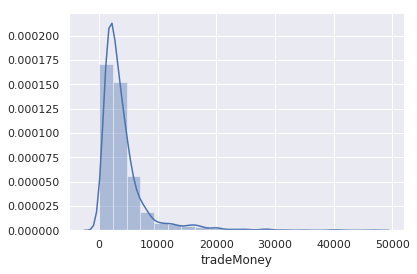

In [15]:
'''buildYear'''
# 如果只存在训练集中，想把这部分样本删除，但是测试集也有就只能填上
# 看一眼分布，决定用中位数填上
print(train[train['buildYear'] == '暂无信息'] .shape)
print(test[test['buildYear'] == '暂无信息'] .shape)
sns.distplot(train[train['buildYear'] == '暂无信息'][target], bins=20)

In [16]:
median_year = data[data['buildYear'] != '暂无信息']['buildYear'].median()
print(median_year)
data['buildYear'][data['buildYear'] == '暂无信息'] = median_year
data['buildYear'] = data['buildYear'].astype(int)
object_col.remove('buildYear')

2002.0


其他    28991
精装    10899
简装     1169
毛坯      311
Name: houseDecoration, dtype: int64
其他    1981
精装     370
简装     102
毛坯      16
Name: houseDecoration, dtype: int64


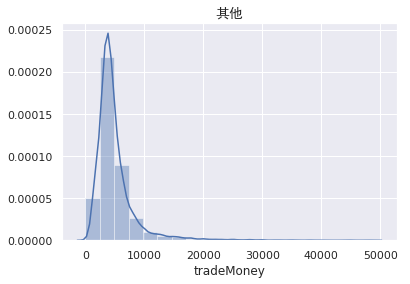

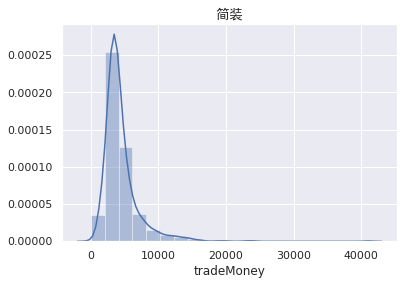

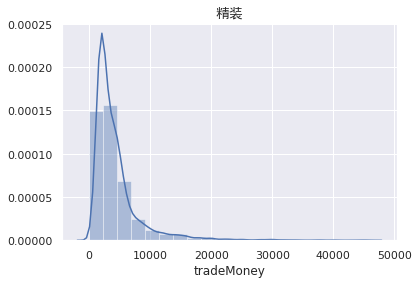

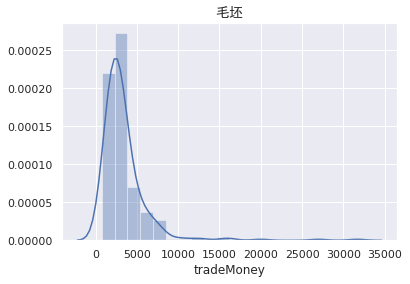

In [17]:
'''houseDecoration'''
# '其他'的比例太高了，简装和精装的区别也不明显，考虑将该特征删除
print(train['houseDecoration'].value_counts())
print(test['houseDecoration'].value_counts())
from matplotlib.font_manager import FontProperties  
%matplotlib inline
font = FontProperties(fname="/notebooks/simhei.ttc", size=14) 

for i in train['houseDecoration'].unique():
    sns.distplot(train[train['houseDecoration']==i][target], bins=20)
    plt.title(i,fontproperties=font)
    plt.show()

In [18]:
columns.remove('houseDecoration')
object_col.remove('houseDecoration')

南       34327
南北       2251
北        2041
暂无数据      955
东南        655
东         550
西         262
西南        248
西北         57
东西         24
Name: houseToward, dtype: int64
暂无数据    1173
南        666
南北       530
西南        73
西北        12
西         11
东南         3
东          1
Name: houseToward, dtype: int64


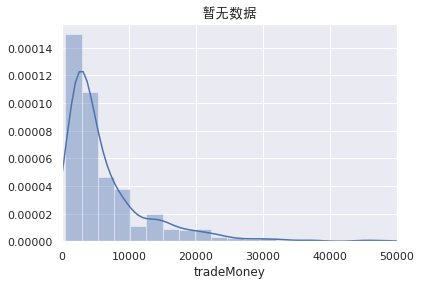

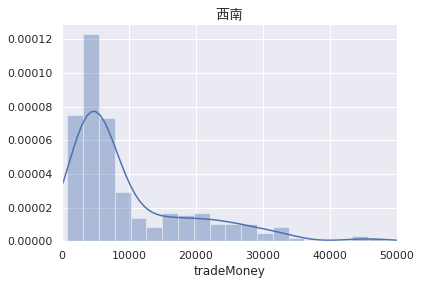

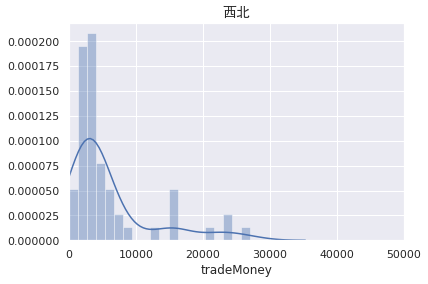

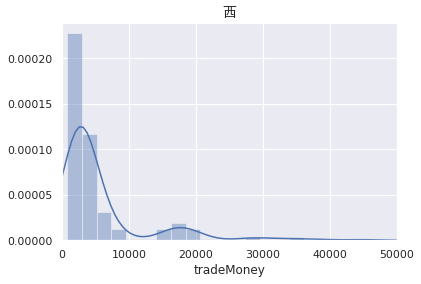

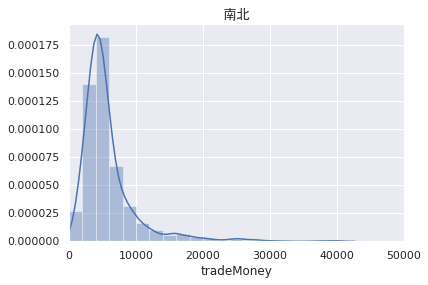

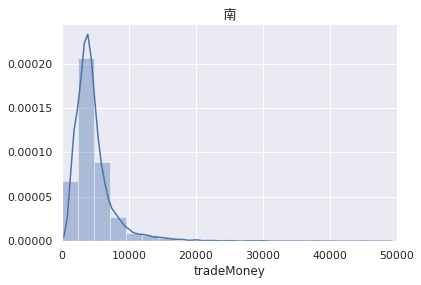

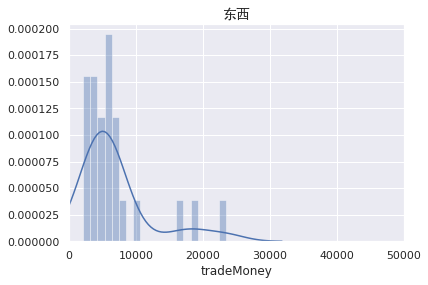

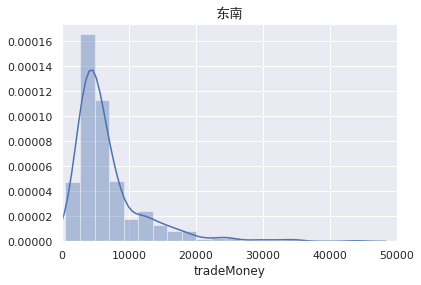

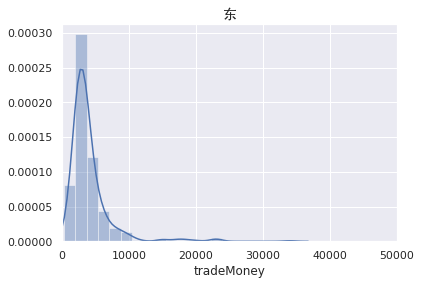

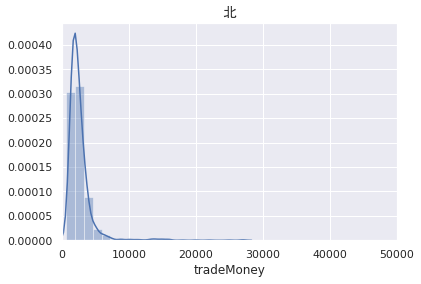

In [19]:
'''houseToward'''
# 常识来讲东南朝向比西北好，但似乎和图上显示的有一些差距
# 测试集中的'暂无数据占了近50%'，且未出现朝北的数据，考虑尝试把‘暂无数据’以‘北’替换
print(train['houseToward'].value_counts())
print(test['houseToward'].value_counts())

for i in train['houseToward'].unique():
    sns.distplot(train[train['houseToward']==i][target], bins=20)
    plt.xlim(0,50000)
    plt.title(i,fontproperties=font)
    plt.show()

In [20]:
data['houseToward'][data['houseToward']=='暂无数据'] = '南'

未知方式    32888
整租       5722
合租       5224
--          5
Name: rentType, dtype: int64


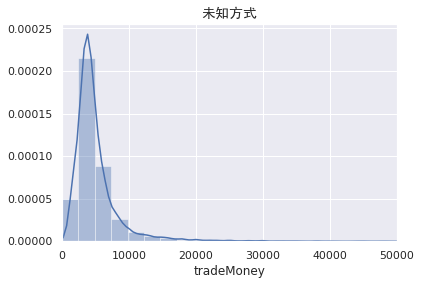

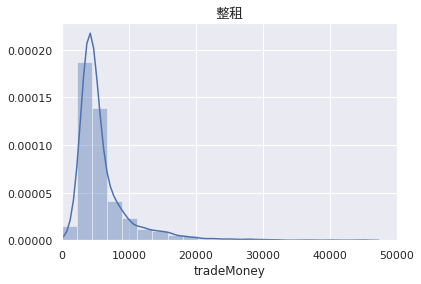

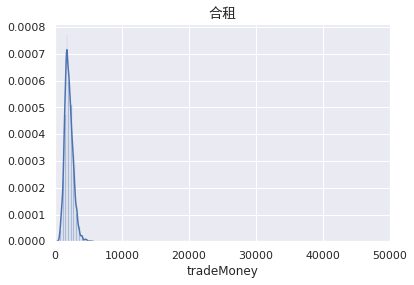

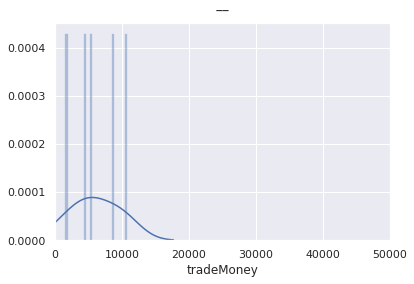

In [21]:
'''租赁方式'''
print(data['rentType'].value_counts())
for i in train['rentType'].unique():
    sns.distplot(train[train['rentType']==i][target], bins=20)
    plt.xlim(0,50000)
    plt.title(i,fontproperties=font)
    plt.show()

In [22]:
# 缺失也很严重，考虑丢弃该特征
print(train[train['rentType'] == '--'] .shape)
print(test[test['rentType'] == '--'] .shape)
print(train[train['rentType'] == '未知方式'] .shape)
print(test[test['rentType'] == '未知方式'] .shape)
columns.remove('rentType')
object_col.remove('rentType')

(5, 51)
(0, 51)
(30703, 51)
(2185, 51)


不同取值个数，可以区分离散特征还是连续特征

In [23]:
nuniq = pd.DataFrame()
nuniq['feature'] = columns
nuniq['num'] = data[columns].nunique().values
print(nuniq)

               feature    num
0                   ID  43839
1                 area  10544
2            houseType    102
3           houseFloor      3
4           totalFloor     54
5          houseToward      9
6        communityName   4221
7                 city      1
8               region     15
9                plate     66
10           buildYear     79
11     saleSecHouseNum     28
12    subwayStationNum     13
13       busStationNum     59
14      interSchoolNum      7
15           schoolNum     44
16    privateSchoolNum     17
17         hospitalNum     11
18        drugStoreNum     42
19              gymNum     39
20             bankNum     45
21             shopNum     56
22             parkNum     18
23             mallNum     17
24      superMarketNum     49
25     totalTradeMoney    706
26      totalTradeArea    707
27      tradeMeanPrice    707
28         tradeSecNum    334
29  totalNewTradeMoney    561
30   totalNewTradeArea    535
31   tradeNewMeanPrice    560
32        

In [24]:
nuniq.set_index('feature',drop=True,inplace=True)
nuniq.loc[object_col] 

,num
feature,
city,1
communityName,4221
houseFloor,3
houseToward,9
houseType,102
plate,66
region,15
tradeTime,361


结合nunique值，对字符类型的特征编码

In [25]:
data['room'] = data['houseType'].apply(lambda x : x.split('室')[0][-1]).astype(int)
data['living'] = data['houseType'].apply(lambda x : x.split('厅')[0][-1]).astype(int)
data['toilet'] = data['houseType'].apply(lambda x : x.split('卫')[0][-1]).astype(int)
columns.remove('houseType')
columns.extend(['room','living','toilet'])
object_col.remove('houseType')

In [26]:
data['tradeYear'] = data['tradeTime'].apply(lambda x : x.split('/')[0]).astype(int)
data['tradeMonth'] = data['tradeTime'].apply(lambda x : x.split('/')[1]).astype(int)
data['tradeDate'] = data['tradeTime'].apply(lambda x : x.split('/')[2]).astype(int)
columns.remove('tradeTime')
columns.extend(['tradeYear','tradeMonth','tradeDate'])
object_col.remove('tradeTime')

In [27]:
from sklearn.preprocessing import LabelEncoder

for i in object_col:
    lbl = LabelEncoder()
    data[i] = lbl.fit_transform(data[i])

再次查看nunique值信息

In [28]:
nuniq = pd.DataFrame()
nuniq['feature'] = data.columns.tolist()
nuniq['num'] = data.nunique().values
nuniq

,feature,num
0,ID,43839
1,area,10544
2,rentType,4
3,houseType,102
4,houseFloor,3
5,totalFloor,54
6,houseToward,9
7,houseDecoration,4
8,communityName,4221
9,city,1


In [29]:
# 删除ID，定值列
columns.remove('ID')
columns.remove('city')
columns.remove('tradeYear')
len(columns)

49

训练集和测试集的特征分布对比,如果有明显差异需重新采样训练集

In [30]:
train = data[data[target] != -1]
test = data[data[target] == -1]

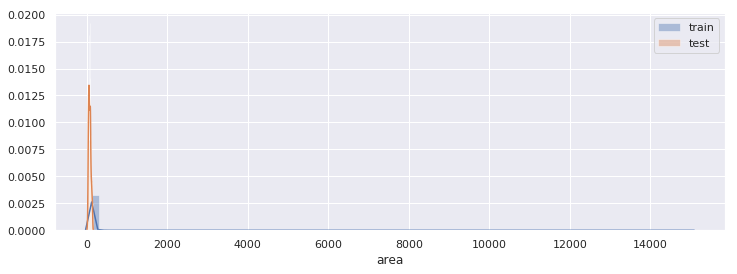

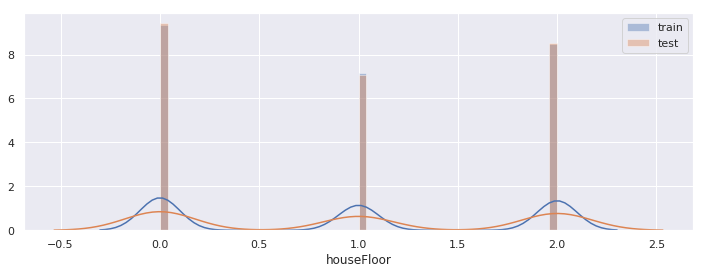

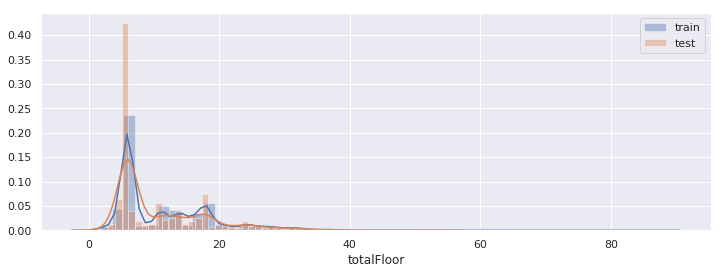

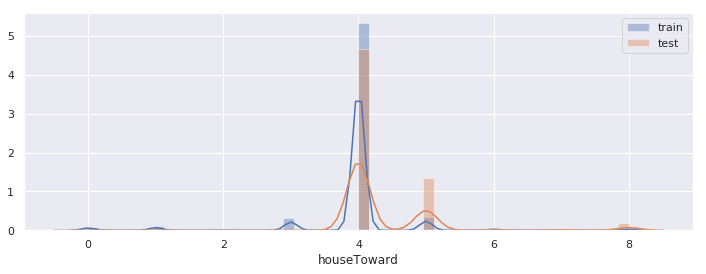

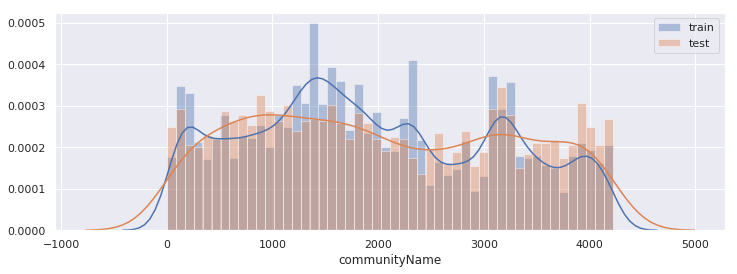

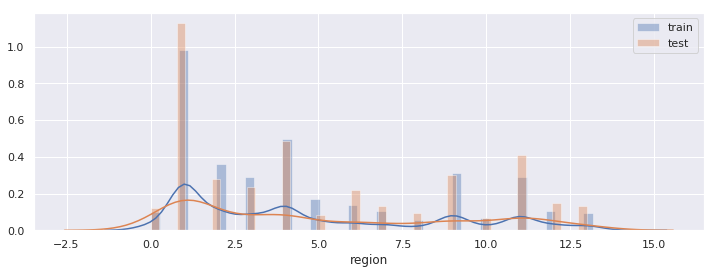

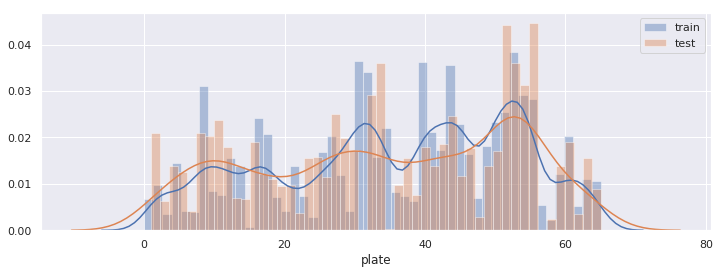

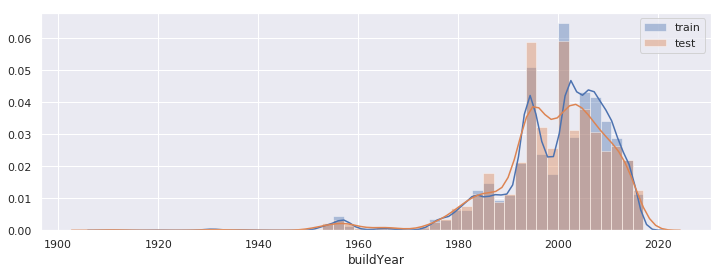

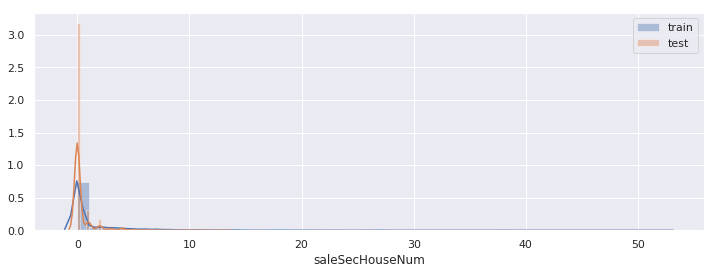

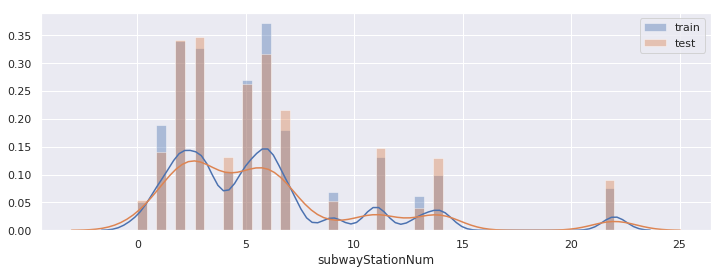

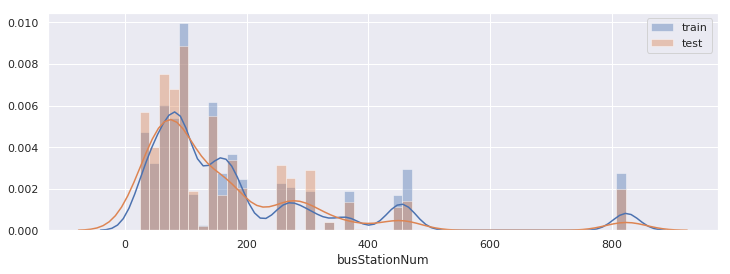

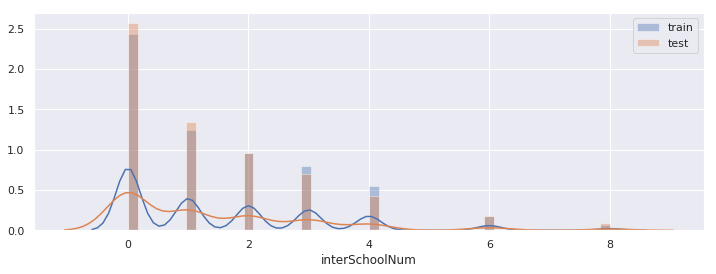

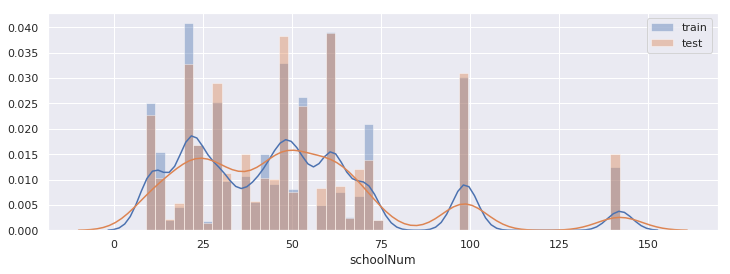

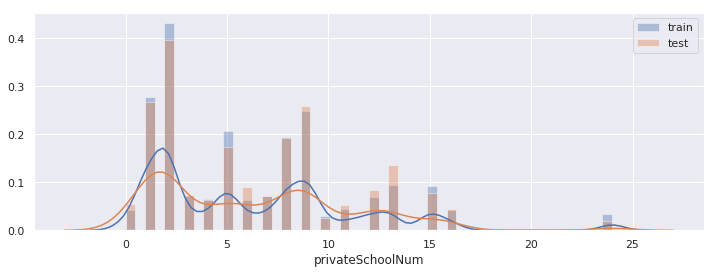

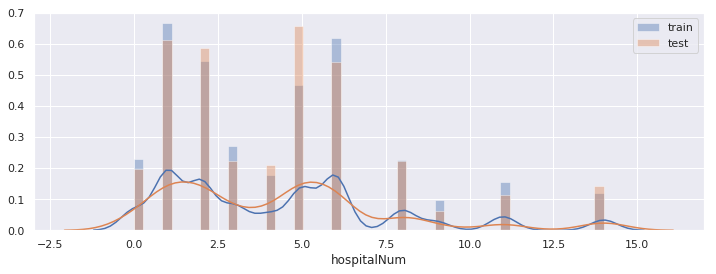

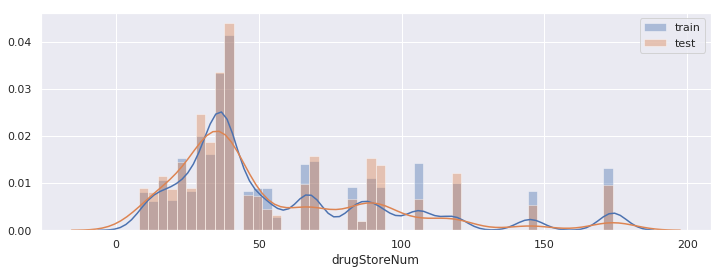

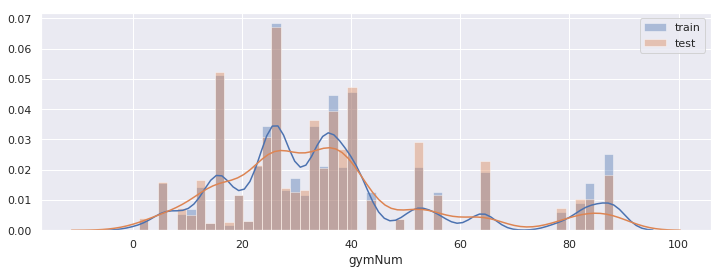

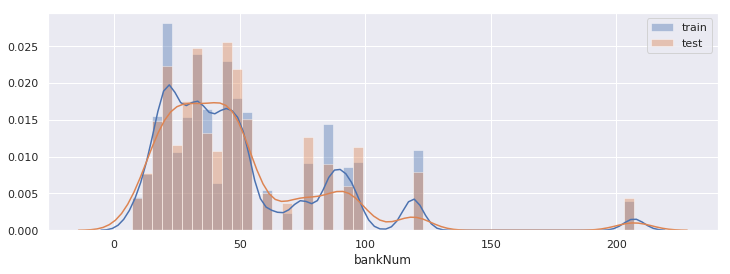

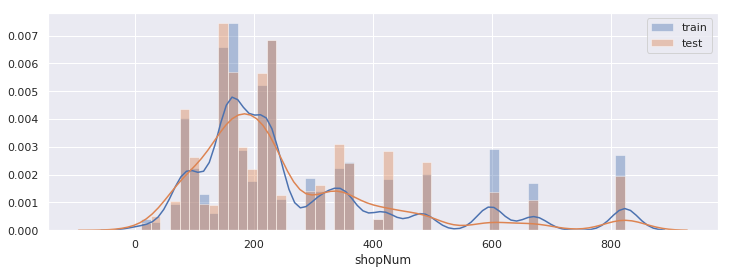

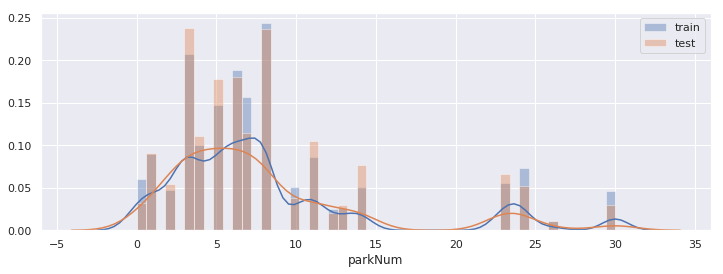

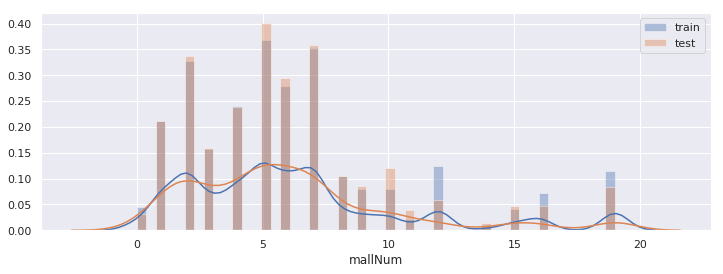

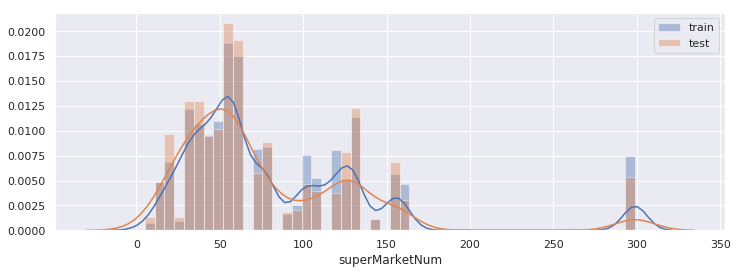

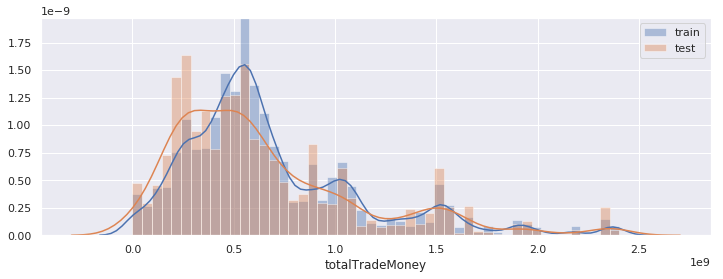

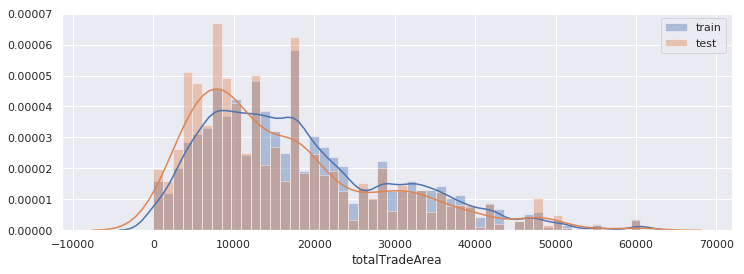

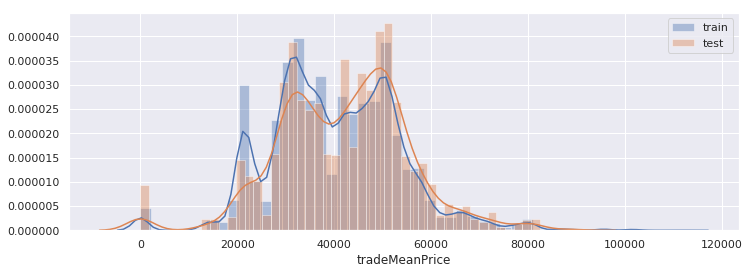

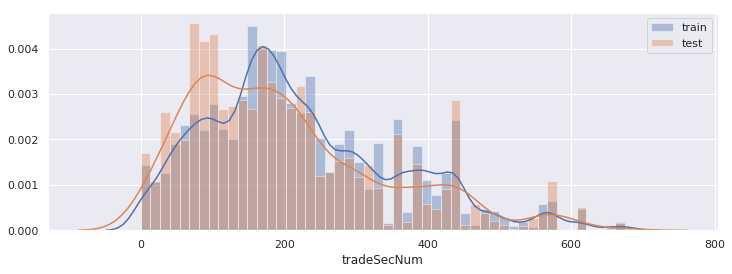

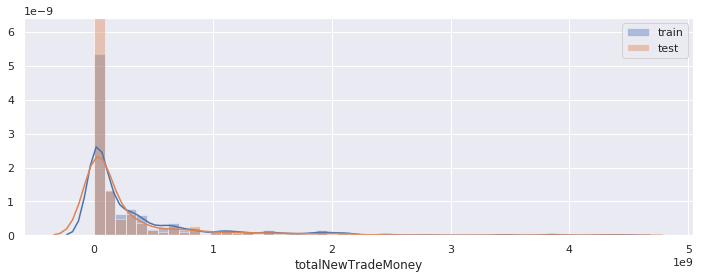

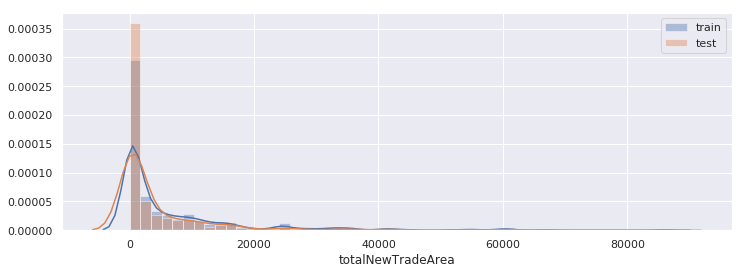

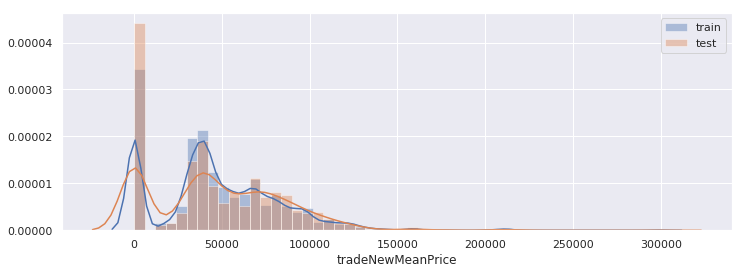

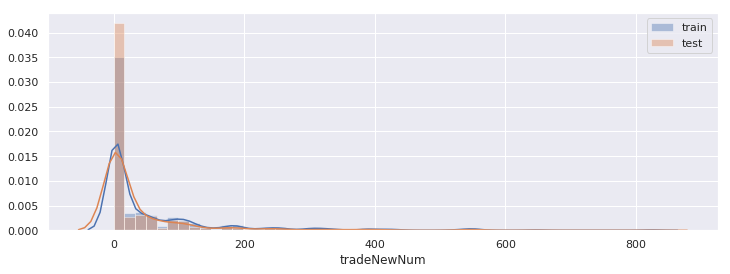

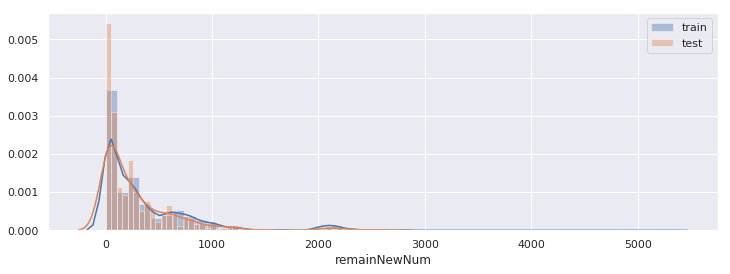

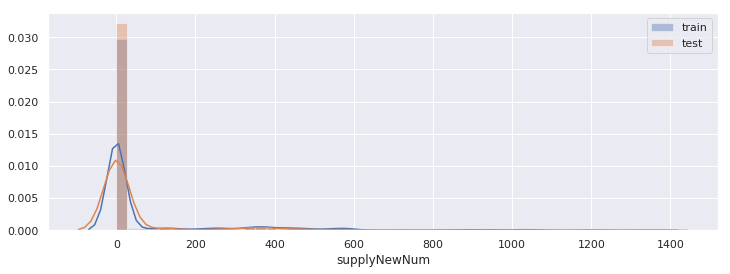

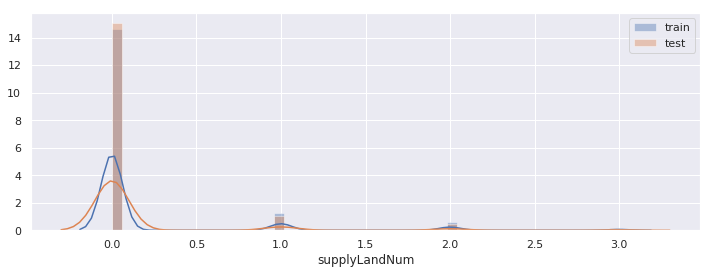

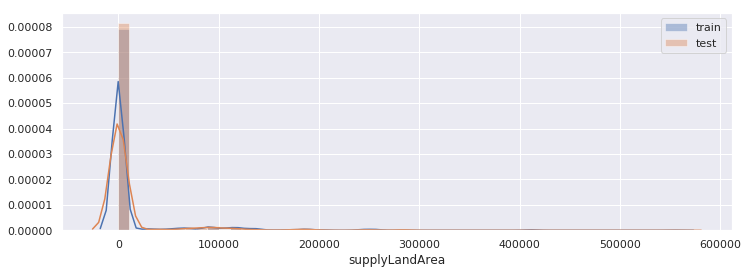

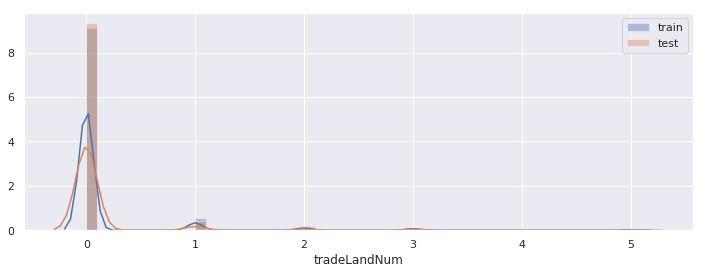

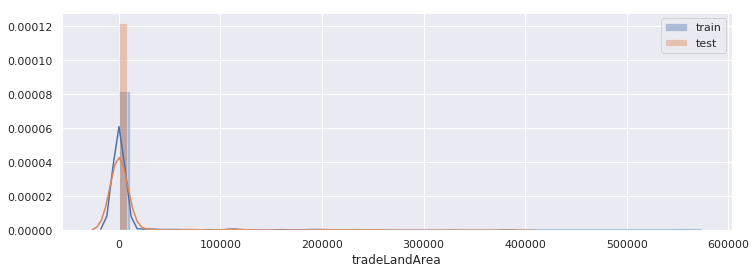

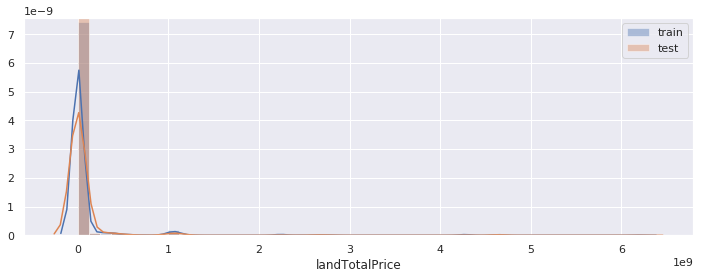

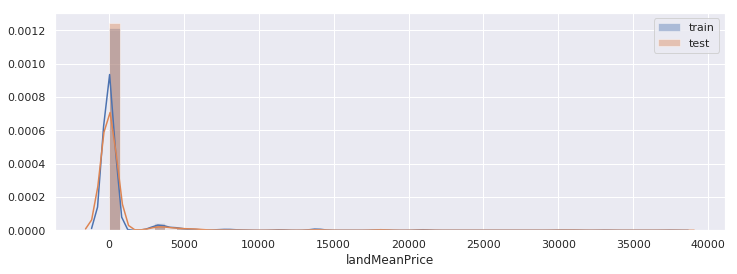

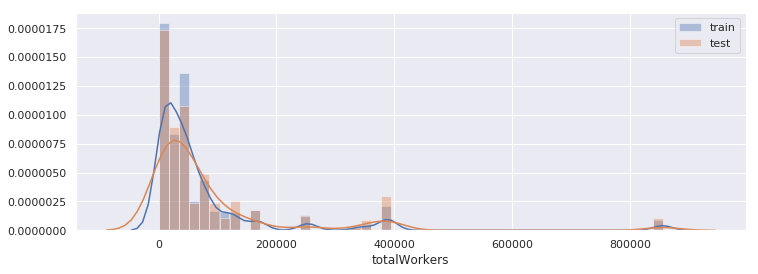

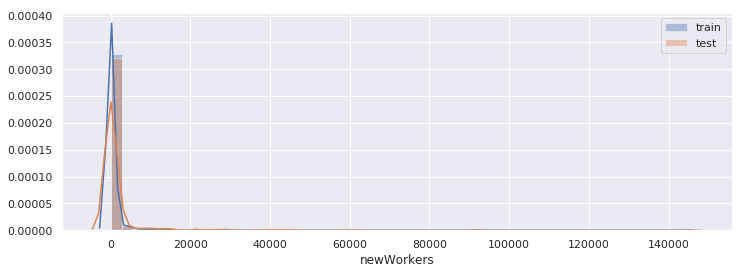

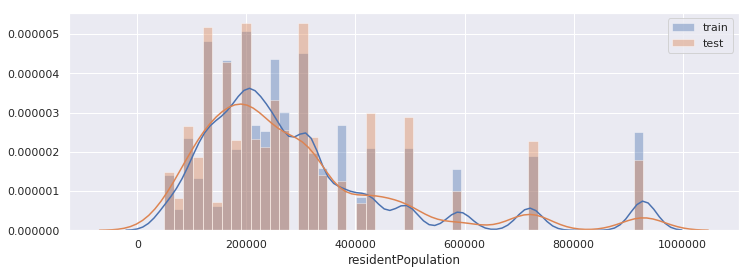

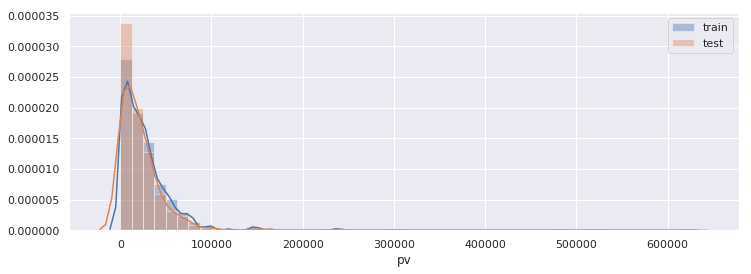

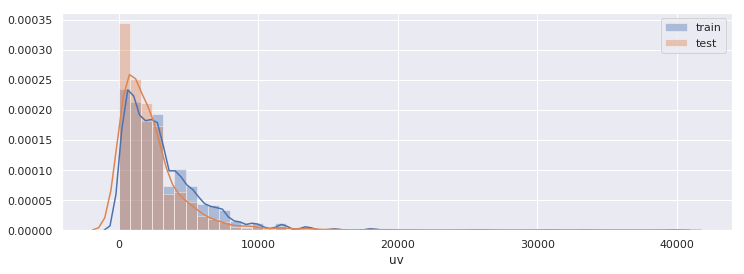

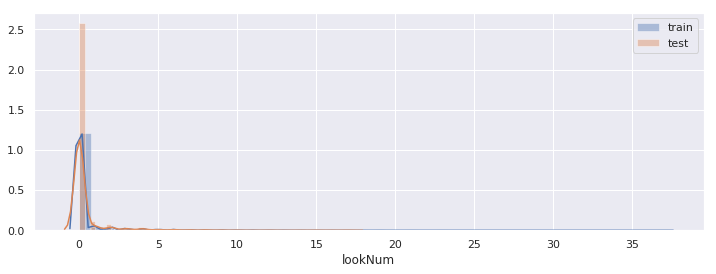

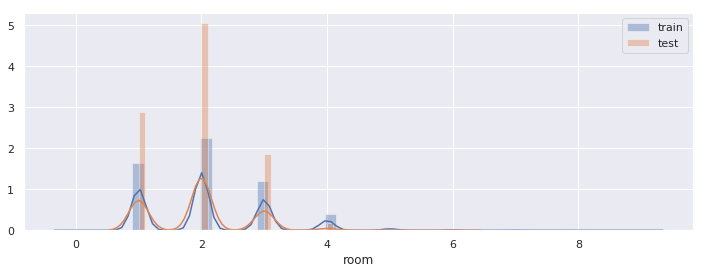

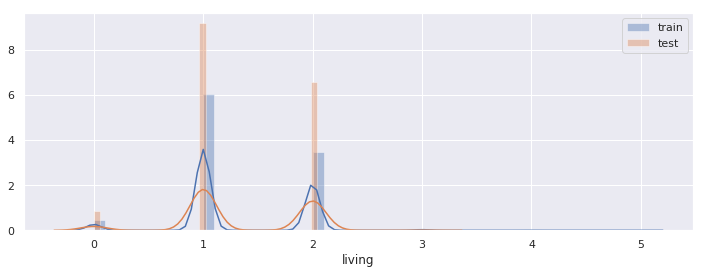

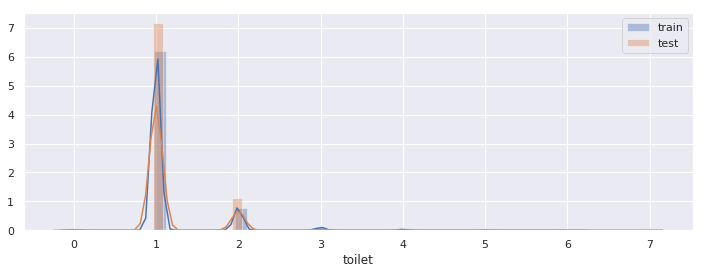

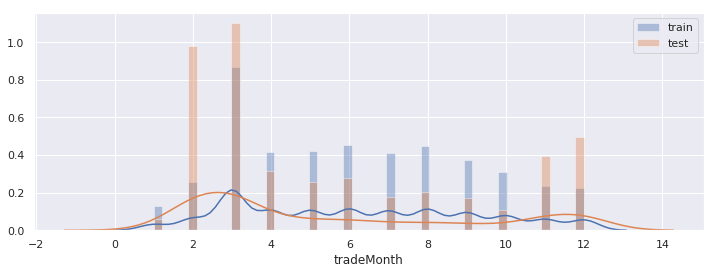

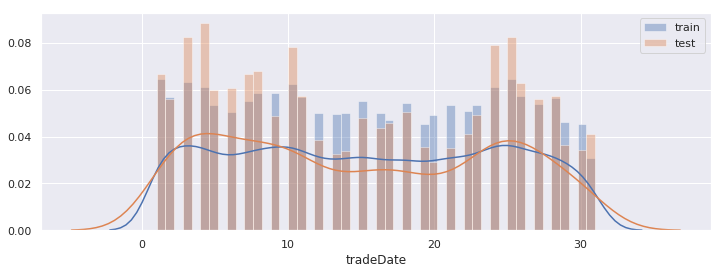

In [31]:
for i,col in enumerate(columns):
    plt.figure(figsize=(12,4))
    sns.distplot(train[col], bins=50)
    sns.distplot(test[col], bins=50) 
    plt.legend(['train','test'])

特征与Label的相关性,没有强相关的特征

In [32]:
relate_cols = columns[:]
relate_cols.append(target)
train[relate_cols].corr('pearson')[target]

area                  0.356156
houseFloor           -0.016717
totalFloor            0.274534
houseToward           0.084371
communityName         0.036801
region                0.034275
plate                 0.002300
buildYear             0.107705
saleSecHouseNum      -0.001721
subwayStationNum      0.027174
busStationNum        -0.218048
interSchoolNum        0.067309
schoolNum            -0.043049
privateSchoolNum      0.051340
hospitalNum          -0.063170
drugStoreNum         -0.199238
gymNum                0.087145
bankNum               0.069156
shopNum              -0.208476
parkNum              -0.068582
mallNum              -0.026318
superMarketNum       -0.189437
totalTradeMoney       0.128255
totalTradeArea       -0.054949
tradeMeanPrice        0.308112
tradeSecNum          -0.010390
totalNewTradeMoney    0.038166
totalNewTradeArea    -0.064329
tradeNewMeanPrice     0.252552
tradeNewNum          -0.084565
remainNewNum         -0.113608
supplyNewNum         -0.065287
supplyLa

In [33]:
train[relate_cols].corr('spearman')[target]

area                  0.598674
houseFloor           -0.022285
totalFloor            0.171336
houseToward           0.170854
communityName         0.020695
region                0.003290
plate                 0.014638
buildYear             0.027472
saleSecHouseNum       0.093521
subwayStationNum      0.044553
busStationNum        -0.332142
interSchoolNum       -0.035369
schoolNum            -0.066613
privateSchoolNum      0.147780
hospitalNum          -0.048874
drugStoreNum         -0.249368
gymNum                0.095655
bankNum              -0.015155
shopNum              -0.245235
parkNum              -0.037672
mallNum              -0.028880
superMarketNum       -0.271225
totalTradeMoney       0.107529
totalTradeArea       -0.106655
tradeMeanPrice        0.430326
tradeSecNum          -0.080408
totalNewTradeMoney   -0.031020
totalNewTradeArea    -0.112169
tradeNewMeanPrice     0.285600
tradeNewNum          -0.131072
remainNewNum         -0.183239
supplyNewNum         -0.098710
supplyLa

In [34]:
train[relate_cols].corr('kendall')[target]

area                  0.443012
houseFloor           -0.017149
totalFloor            0.128452
houseToward           0.137806
communityName         0.014117
region                0.002891
plate                 0.009232
buildYear             0.020840
saleSecHouseNum       0.071585
subwayStationNum      0.031249
busStationNum        -0.226839
interSchoolNum       -0.026601
schoolNum            -0.044683
privateSchoolNum      0.104634
hospitalNum          -0.033402
drugStoreNum         -0.170652
gymNum                0.063937
bankNum              -0.008523
shopNum              -0.167432
parkNum              -0.026142
mallNum              -0.019795
superMarketNum       -0.186114
totalTradeMoney       0.071349
totalTradeArea       -0.072157
tradeMeanPrice        0.299355
tradeSecNum          -0.055760
totalNewTradeMoney   -0.022120
totalNewTradeArea    -0.075648
tradeNewMeanPrice     0.197663
tradeNewNum          -0.089169
remainNewNum         -0.122426
supplyNewNum         -0.076976
supplyLa

特征-预测目标的散点图

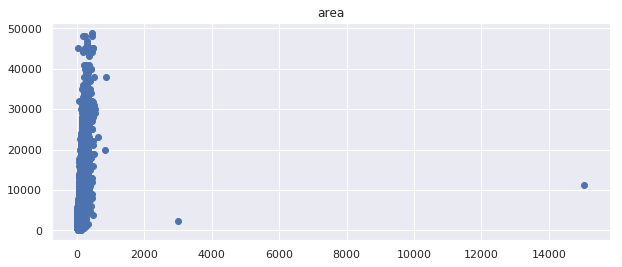

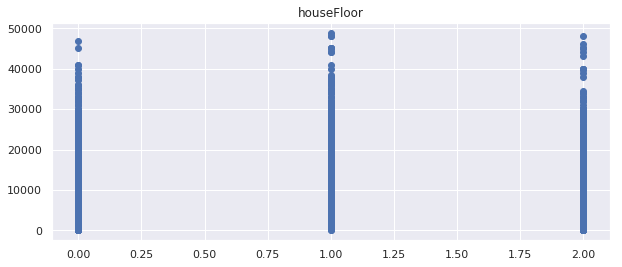

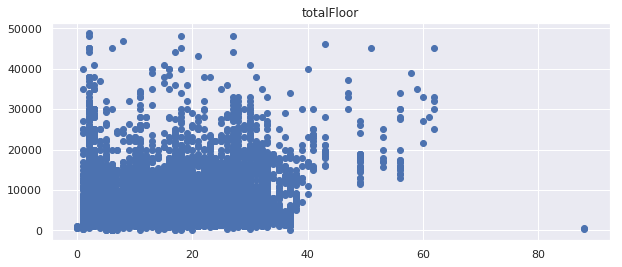

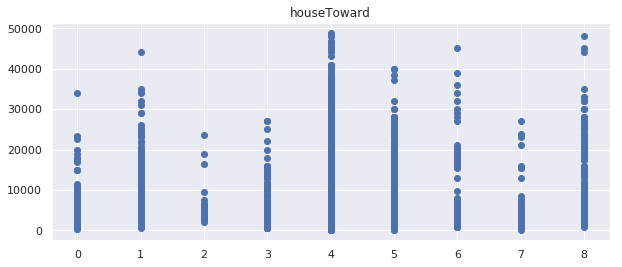

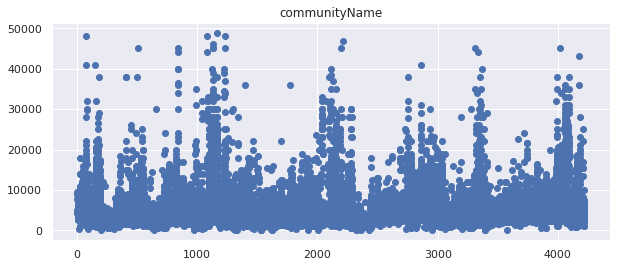

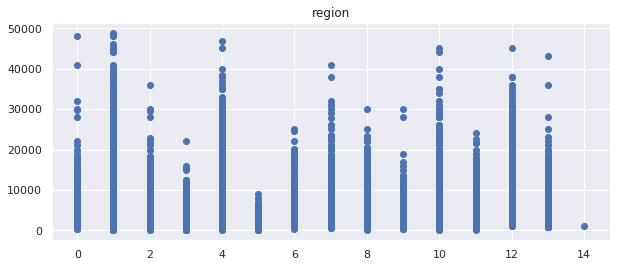

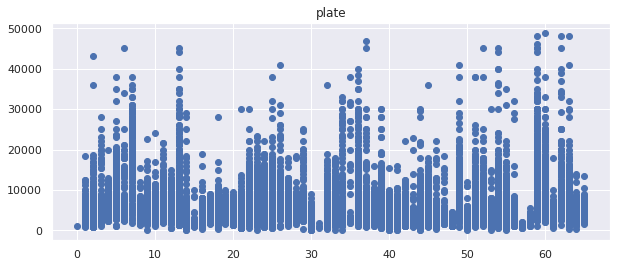

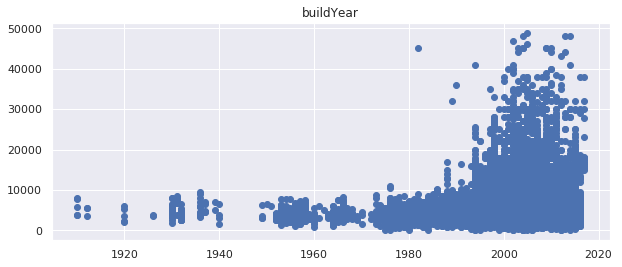

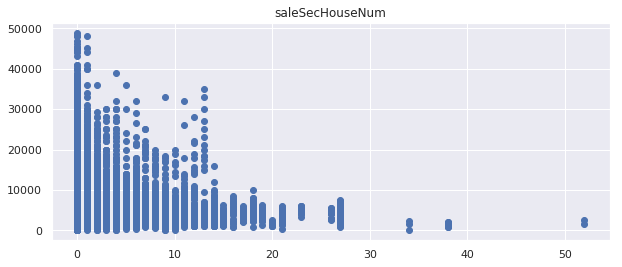

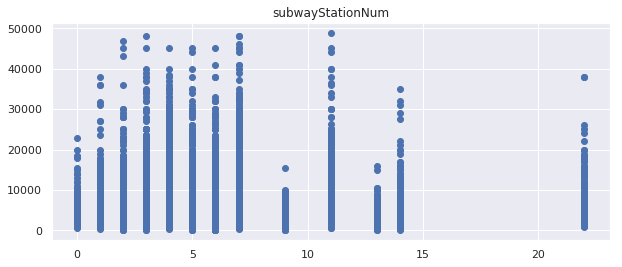

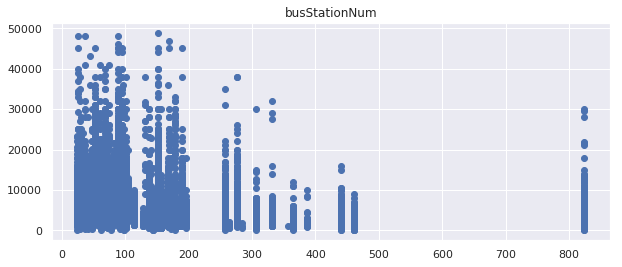

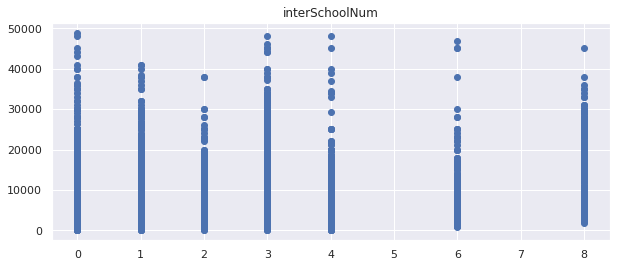

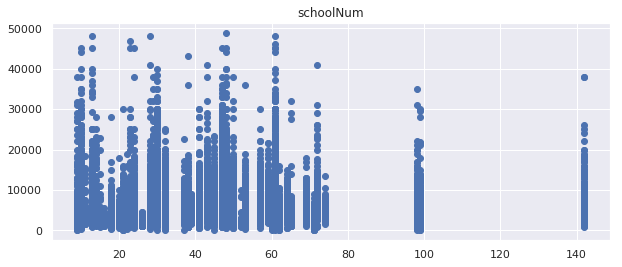

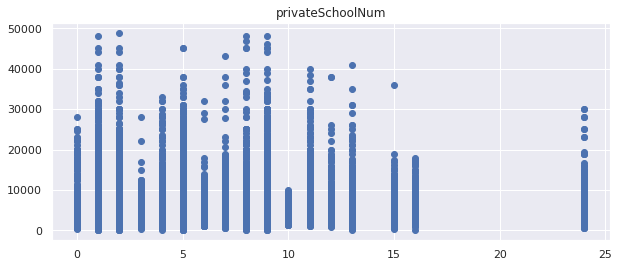

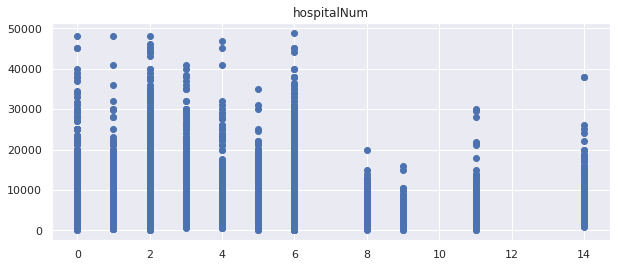

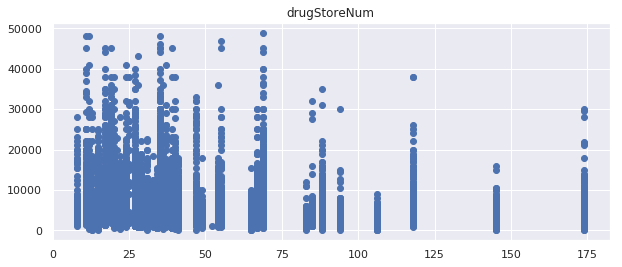

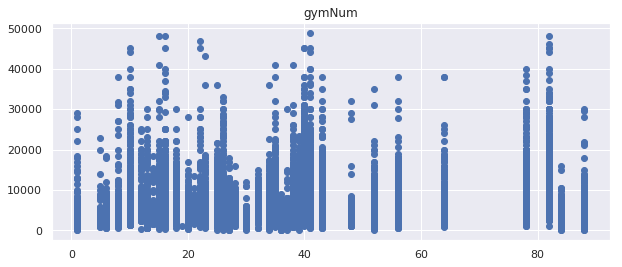

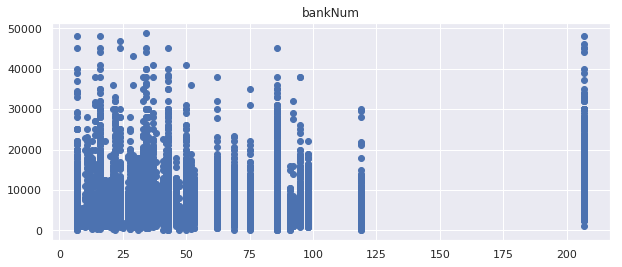

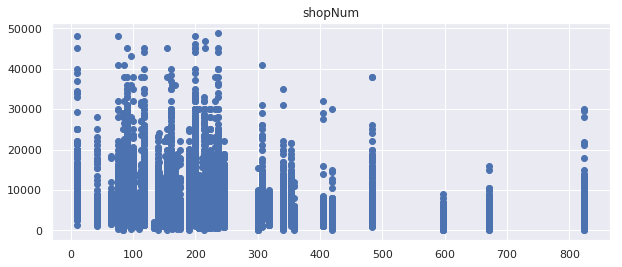

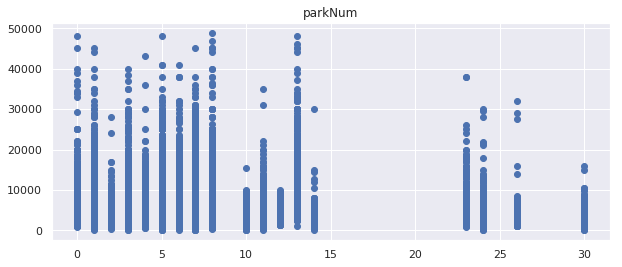

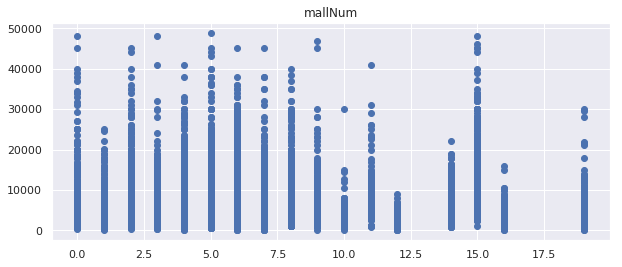

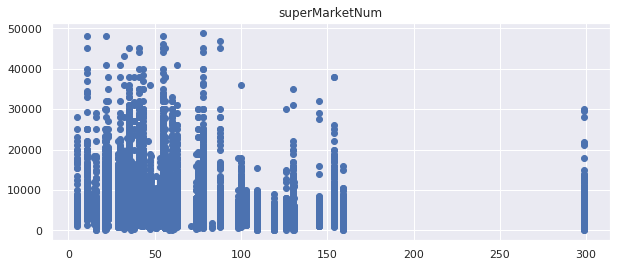

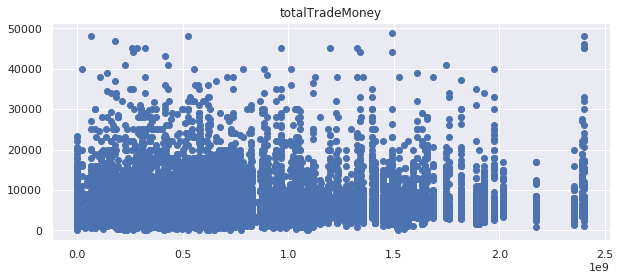

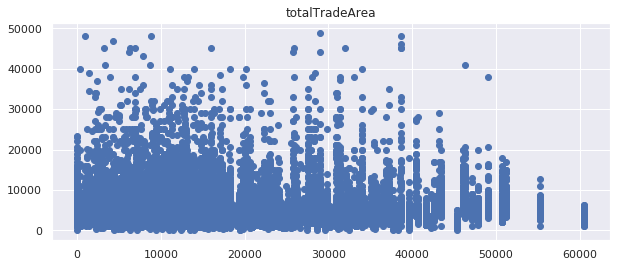

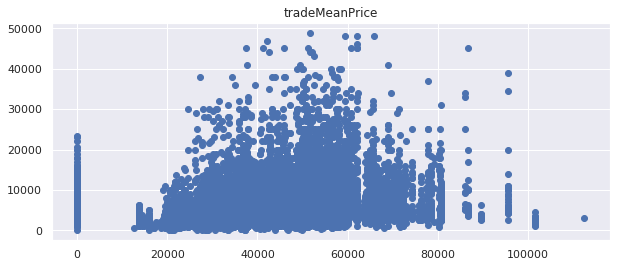

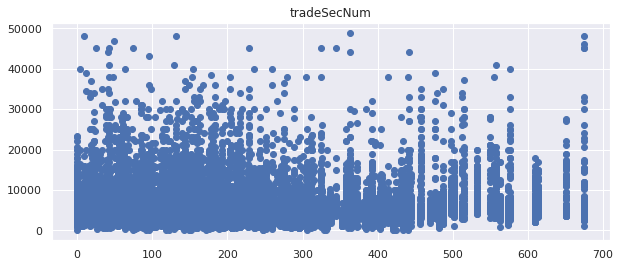

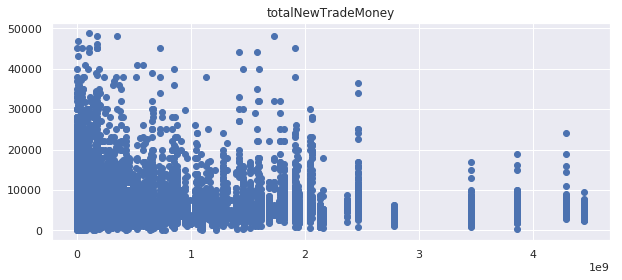

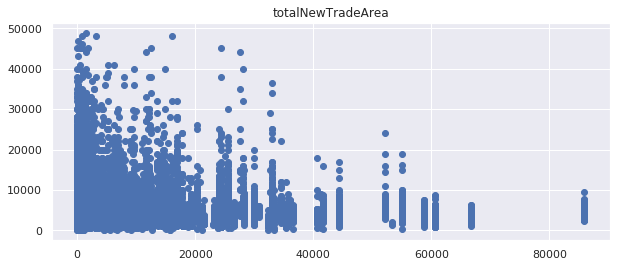

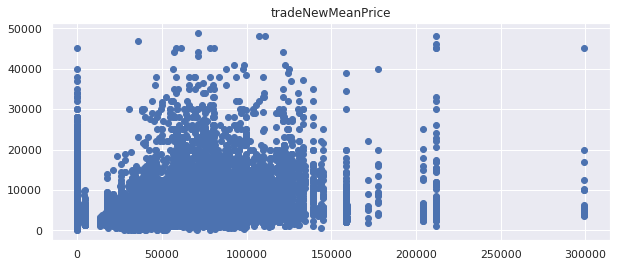

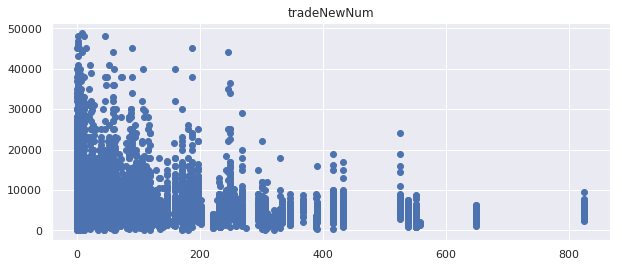

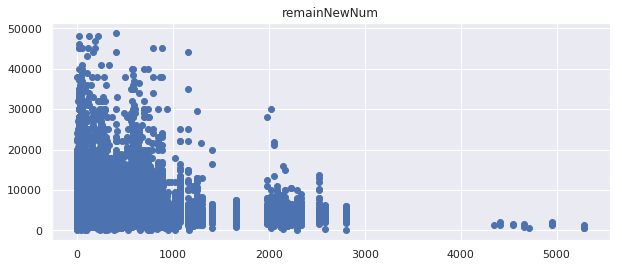

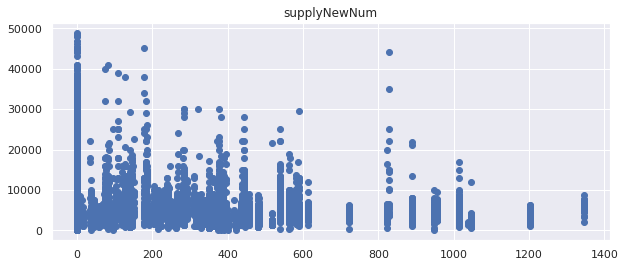

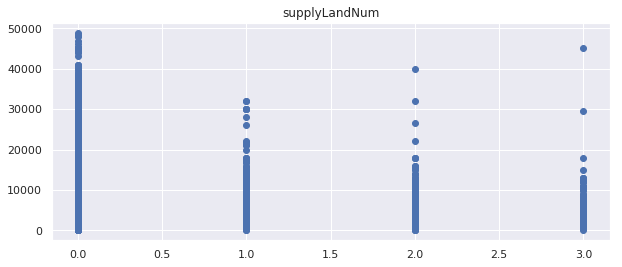

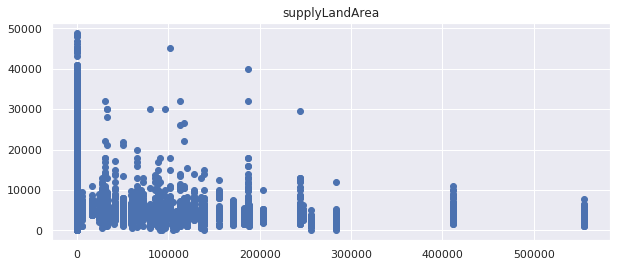

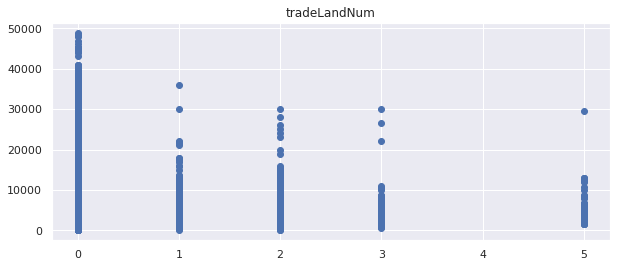

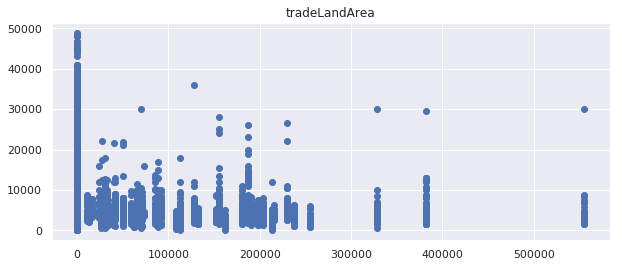

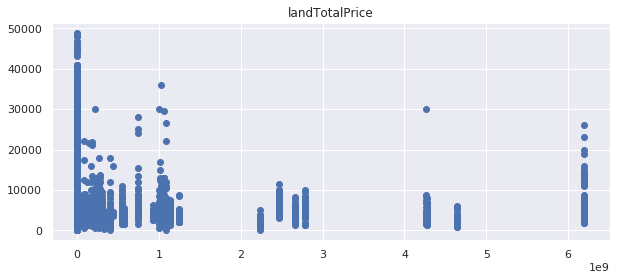

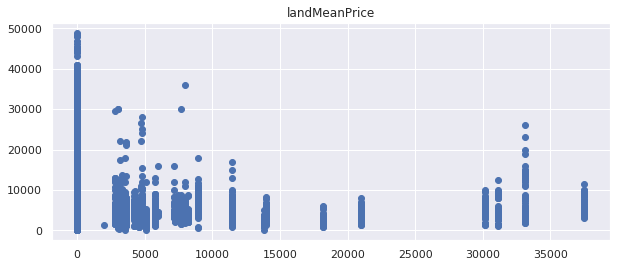

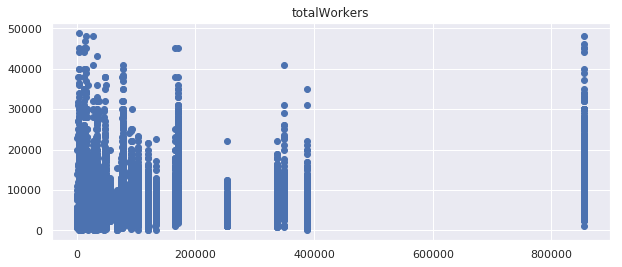

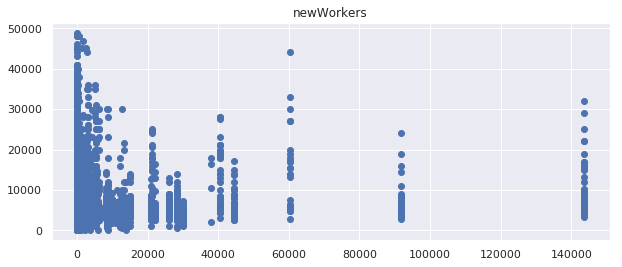

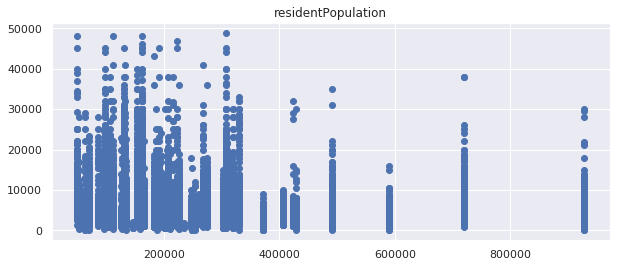

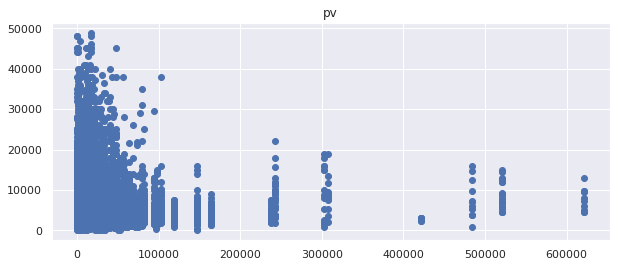

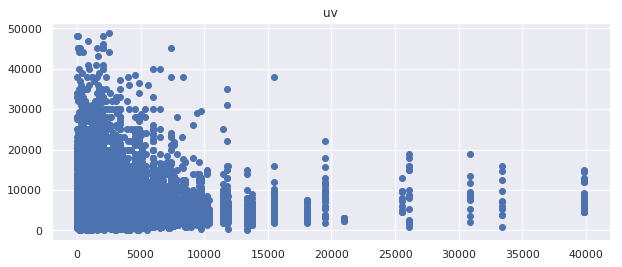

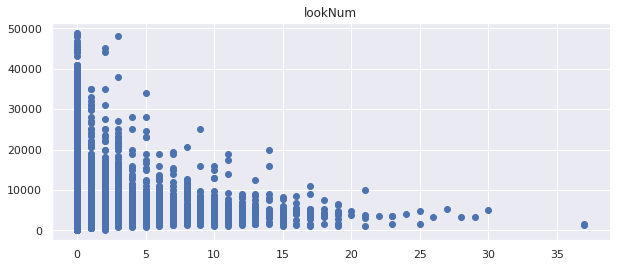

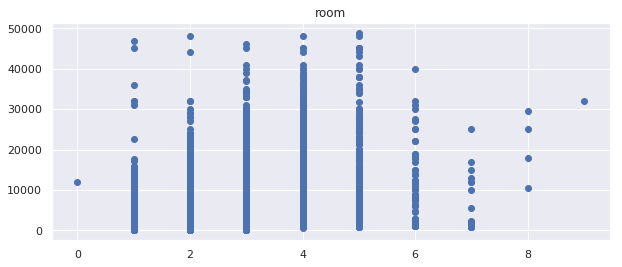

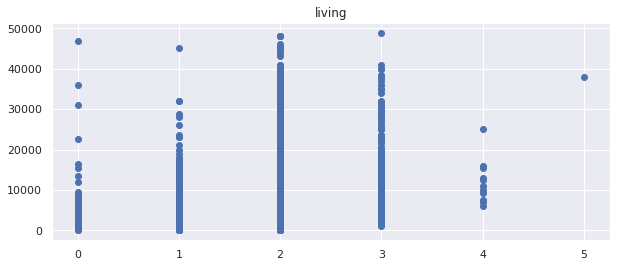

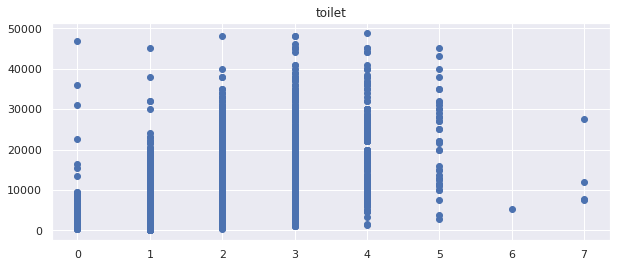

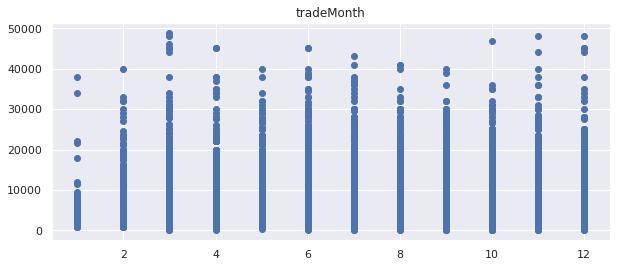

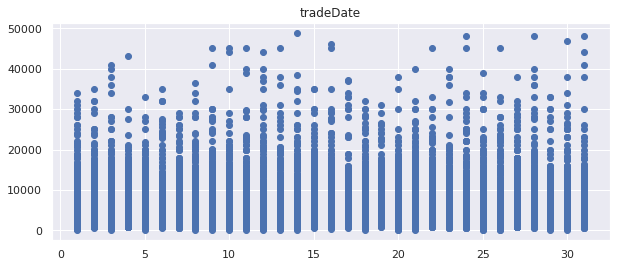

In [35]:
for i in columns:
    plt.figure(figsize=(10,4))
    plt.scatter(train[i],train[target])
    plt.title(i)
    plt.show()

#### 划分训练集和测试集直接扔LGB

In [54]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(train[columns],train[target], test_size=0.3, random_state=666)

In [55]:
print(X_train.shape,y_train.shape)
print(X_test.shape,y_test.shape)

(28959, 49) (28959,)
(12411, 49) (12411,)


In [56]:
import lightgbm as lgb
from sklearn.metrics import r2_score
lgb_model = lgb.LGBMRegressor(boosting_type="gbdt", objective='regression',metric='mse')
lgb_model.fit(X_train, y_train,
              eval_set=[(X_train, y_train),(X_test, y_test)],
              early_stopping_rounds=10)

[1]	training's l2: 1.20233e+07	valid_1's l2: 1.15045e+07
Training until validation scores don't improve for 10 rounds.
[2]	training's l2: 1.03412e+07	valid_1's l2: 9.9225e+06
[3]	training's l2: 8.95768e+06	valid_1's l2: 8.63272e+06
[4]	training's l2: 7.81854e+06	valid_1's l2: 7.5526e+06
[5]	training's l2: 6.87883e+06	valid_1's l2: 6.65432e+06
[6]	training's l2: 6.09375e+06	valid_1's l2: 5.93996e+06
[7]	training's l2: 5.44341e+06	valid_1's l2: 5.32127e+06
[8]	training's l2: 4.89863e+06	valid_1's l2: 4.83529e+06
[9]	training's l2: 4.4363e+06	valid_1's l2: 4.40436e+06
[10]	training's l2: 4.05708e+06	valid_1's l2: 4.04971e+06
[11]	training's l2: 3.72491e+06	valid_1's l2: 3.75246e+06
[12]	training's l2: 3.44405e+06	valid_1's l2: 3.48872e+06
[13]	training's l2: 3.20742e+06	valid_1's l2: 3.27005e+06
[14]	training's l2: 3.01572e+06	valid_1's l2: 3.10058e+06
[15]	training's l2: 2.83872e+06	valid_1's l2: 2.95932e+06
[16]	training's l2: 2.68905e+06	valid_1's l2: 2.83207e+06
[17]	training's l2: 2.

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
       importance_type='split', learning_rate=0.1, max_depth=-1,
       metric='mse', min_child_samples=20, min_child_weight=0.001,
       min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=31,
       objective='regression', random_state=None, reg_alpha=0.0,
       reg_lambda=0.0, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=0)

#### 评估

In [57]:
'''线下'''
pred_train = lgb_model.predict(X_train)
train_loss = r2_score(y_train,pred_train)
print("train r2 score:{}".format(train_loss))

pred_test = lgb_model.predict(X_test)
test_loss = r2_score(y_test,pred_test)
print("test r2 score:{}".format(test_loss))


train r2 score:0.9213761694998894
test r2 score:0.8678756124560125


In [58]:
eval_data = pd.read_csv('./data/评分文件/sub_a_913.csv')
pred_eval = lgb_model.predict(test[columns])
r2_score(eval_data['pre'],pred_eval)

0.9084855623871902